ATAN Model Training:
Score: 0.920898 | Training: ========================================                   

Linear Model Training:
Score: 0.576743 | Training: ========================================                   

Combo Model Training
Score: 0.939538 | Training: ========================================                   

Plotted Results:


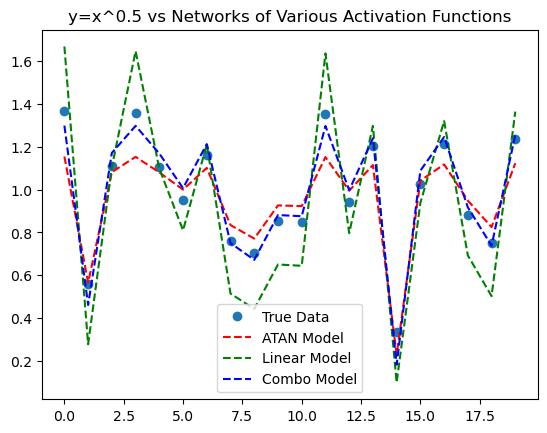

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import mcnets as mc

# Data to fit to (f(x) = x^0.5)
# You can increase the number of samples by changing the X variable
X = np.random.rand(20)*2 # Gives domain of [0, 2)
Y = X**0.5

# Assemble a few models to test
net_atan  = mc.AdvNet(1, [25], 1, 'atan')
net_lin   = mc.AdvNet(1, [25], 1)
net_combo = mc.AdvNet(1, [25], 1, ['relu', 'elu', 'lin'])

# An equal alternative definition for the ATAN model:
# net_atan = AdvNet(1, [25], 1, ['atan', 'atan', 'atan'])

# An equal alternative definition for the linear model (lin is default):
# net_atan = AdvNet(1, [25], 1)  

# Train-Test Split (Taking only the train group)
x, y, _, _ = mc.TTSplit(X, Y, percentTrain=50)

# Fit the models to the training data group
print("ATAN Model Training:")
net_atan  = net_atan.Fit(x, y, useFast=False)

print("\nLinear Model Training:")
net_lin   = net_lin.Fit(x, y)

print("\nCombo Model Training")
net_combo = net_combo.Fit(x, y)

# Get the models predictions to the full data set
ym_atan  = net_atan.Predict(X, useFast=False)
ym_lin   = net_lin.Predict(X)
ym_combo = net_combo.Predict(X)

# Plot and compare the results of the models
print("\nPlotted Results:")
plt.plot(Y, 'o')
plt.plot(ym_atan, 'r--')
plt.plot(ym_lin, 'g--')
plt.plot(ym_combo, 'b--')
plt.title(f"y=x^0.5 vs Networks of Various Activation Functions")
plt.legend(["True Data", "ATAN Model", "Linear Model", "Combo Model"])
plt.show()

In [ ]:
# CNN Tests
inputXSize = 16
inputYSize = 13

# Make divisions based on odd/evenness
def MakeRange(inSize:int):
    dom = []
    if inSize%2 == 0:
        step = inSize//2
        for i in range(2):
            dom.append([step*i, step*(i+1)-1])
    else:
        adjust = 0
        step = inSize//3
        rem = inSize - step*3
        for i in range(3):
            if rem > 0:
                dom.append([step*i+adjust, step*(i+1)+adjust])
                rem -= 1
                adjust += 1
            else:
                dom.append([step*i+adjust, step*(i+1)-1+adjust])
    return dom

xRanges = MakeRange(inputXSize)
yRanges = MakeRange(inputYSize)

print(xRanges, yRanges)

# Get XY matrix

[[0, 7], [8, 15]] [[0, 4], [5, 8], [9, 12]]


In [ ]:
# Microtweak tests
import matplotlib.pyplot as plt
from main import *
import numpy as np
import random as rn
import math as m
from time import perf_counter as pc

# Functions
def getMAE(net:AdvNet, X, Y):
    # Get Mean/Average Error
    netVals = Forecast(net, X, plotResults=False)
    MAE = 0
    for yhi, yi in zip(netVals, Y):
        MAE += abs(yhi-yi)
    MAE = MAE/len(netVals)
    return MAE

def clip(val:float, minVal, maxVal):
    if val > maxVal:
        return maxVal
    elif val < minVal:
        return minVal
    else:
        return val

def gradientTrain(net:AdvNet, X, Y, itrs:int):
    # Loop design
    # 1 - Get current error
    # 2 - Test error after increasing and decreasing a single weight
    # 3 - Set net to new best, move on to next weight
    #       - ****ASSUME NET IS 2 LAYERS TOTAL****
    #       - Stop loop if improvement is small enough

    # Cycle loop to change tuning precision over time
    for I in range(round(itrs)):
        # Get current tuning precision
        gamma = 2 / (I + 1)

        # Iterate over the net weight arrays
        # This shouldnt be needed for this functions purpose
        # Still included as a general solution
        for WI, weightArr in enumerate(net.weights):
            # Iterate over the net individual weights
            for i, wi in enumerate(weightArr):
                # Get starting error/change
                bestMAE = getMAE(net, X, Y)
                dW = abs(2 * (rn.random() - 0.5) * gamma)

                # Test change up
                Wup = clip(wi + dW, -1, 1)
                net.weights[WI][i] = Wup
                upMAE = getMAE(net, X, Y)

                # Test change down
                Wdown = clip(wi - dW, -1, 1)
                net.weights[WI][i] = Wdown
                downMAE = getMAE(net, X, Y)

                # Apply best weight
                errors = [bestMAE, upMAE, downMAE]
                wiList = [wi, Wup, Wdown]
                bestIndex = errors.index(min(errors))
                net.weights[WI][i] = wiList[bestIndex]
    
    return net, min(errors)
        
# Data
net = AdvNet(4, [], 1, "lin")
X = 4 * (np.random.rand(100, 4) - 0.5)
Y = np.zeros((100,))
for i, xi in enumerate(X):
    Y[i] = np.sum(xi)

# # Do tests
net1 = net.CopyNet()
net2 = net.CopyNet()

print(getMAE(net1, X ,Y))
print(getMAE(net2, X, Y))
print()

t1 = pc()
net1, r2 = genTrain(net1, X, Y, iterations=10,
                    batchSize=100, gamma=1, Silent=True)

t2 = pc()

net2, MAE = gradientTrain(net2, X, Y, itrs=100)
t3 = pc()

print(getMAE(net1, X ,Y))
print(getMAE(net2, X, Y))
print()

print(t2-t1)
print(t3-t2)

1.485287111336854
1.485287111336854

0.0
0.020818701594728047

1.401918200000182
1.5869154999998045


In [ ]:
# Threading Tests
from main import *
from threading import Thread
import numpy as np
from time import perf_counter as pc

net1 = AdvNet(1, [5], 1, "lin")
net2 = AdvNet(1, [10], 1, "lin")
net3 = AdvNet(1, [15], 1, "lin")

X = np.linspace(0, 2, 200)
Y = np.linspace(0, 2, 200)

# Normal way
t1 = pc()
genTrain(net1, X, Y, iterations=10,
         batchSize=50, gamma=1, R2Goal=1)
genTrain(net2, X, Y, iterations=10,
         batchSize=50, gamma=1, R2Goal=1)
genTrain(net3, X, Y, iterations=10,
         batchSize=50, gamma=1, R2Goal=1)
t2 = pc()

print("Normal Method:")
print(f"{format(t2-t1, '.4f')} Seconds")

# Threaded way
t3 = pc()
T1 = Thread(target=genTrain, args=(net1, X, Y), 
            kwargs={'iterations':10, 'batchSize':50, 'gamma':1, 'R2Goal':1})
T2 = Thread(target=genTrain, args=(net2, X, Y), 
            kwargs={'iterations':10, 'batchSize':50, 'gamma':1, 'R2Goal':1})
T3 = Thread(target=genTrain, args=(net3, X, Y), 
            kwargs={'iterations':10, 'batchSize':50, 'gamma':1, 'R2Goal':1})

T1.start()
T2.start()
T3.start()

T1.join()
T2.join()
T3.join()
t4 = pc()

print("Threaded Method:")
print(f"{format(t4-t3, '.4f')} Seconds")

R2: 1.000000 | Training: ========================================
R2: 1.000000 | Training: ========================================
R2: 1.000000 | Training: ========================================
Normal Method:
5.8331 Seconds
R2: 1.000000 | Training: ========================================R2: 0.999996 | Training: =========-------------------------------
R2: 1.000000 | Training: ========================================
R2: 1.000000 | Training: ========================================
Threaded Method:
5.6816 Seconds


In [ ]:
# Gradient Tests
size = 3
acts = ["ATAN"]
net = AdvNet(1, [15]*(size-1), 1, [rn.choice(acts) for _ in range(size)])

# Data
xData = np.arange(0, 3, 0.5).tolist()
yTrue = [(xi+(rn.random()-0.5))**2 for xi in xData]

# Functions
def getScore(X, Y, NN):
    yHat = [NN.Calculate(xi) for xi in X]
    diffs = [abs(yi-yhi) for yi, yhi in zip(Y, yHat)]
    return sum(diffs)

# Training
# Initial Score
best = getScore(xData, yTrue, net)
bestCopy = best
print(f"Initial Score: {best}\n")

# Training (Standard single batch)
for i in range(3):
    newScore = best + 1
    while newScore > best:
        net2 = net.CopyNet()
        net2.TweakWeights(1/(i+1))
        newScore = getScore(xData, yTrue, net2)
    best = newScore
    print(f"Score {i+1}: {best}")
print()

# Training (gradient)
print("With Gradient:")
dW = None
for i in range(3):
    newScore = bestCopy + 1
    if dW == None:
        while newScore > bestCopy:
            net3 = net.CopyNet()
            dW = net3.TweakWeights(1/(i+1), returnChange=True)
            newScore = getScore(xData, yTrue, net3)
    else:
        for _ in range(20):
            done = False
            dW = [wi/(1.05) for wi in dW]
            net3 = net.CopyNet()
            net3.ApplyTweak(dW)
            newScore = getScore(xData, yTrue, net3)
            if newScore < bestCopy:
                done = True
                print("Used Gradient")
                break
        if not done:
            while newScore > bestCopy:
                net3 = net.CopyNet()
                dW = net3.TweakWeights(1/(i+1), returnChange=True)
                newScore = getScore(xData, yTrue, net3)
    bestCopy = newScore
    print(f"Score {i+1}: {bestCopy}")


Initial Score: 16.307604159500553

Score 1: 11.745016447379008
Score 2: 11.738644745022901


KeyboardInterrupt: 